<a href="https://colab.research.google.com/github/sasaigoli05/BIOL105-CompBioModule/blob/main/Module-BetaTest4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# For Now, to get started, navigate to Runtime > Run all. This will run all the cells, but will ensure they run without errors. To follow the activity, make sure to go cell by cell.

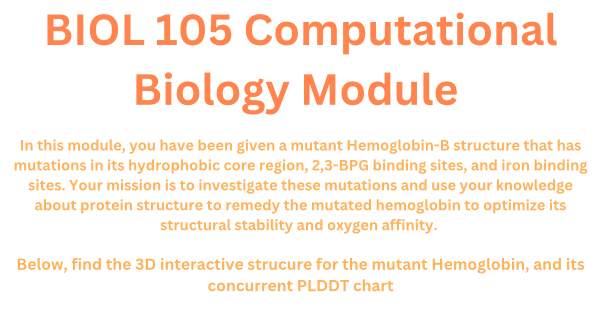

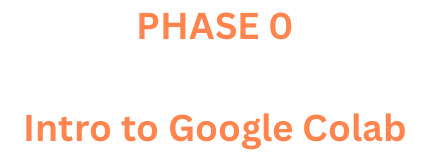

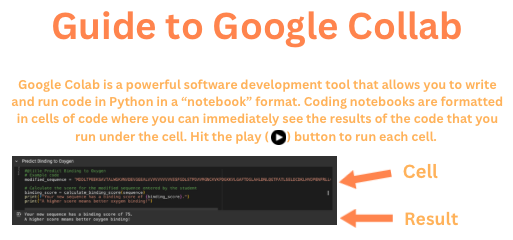

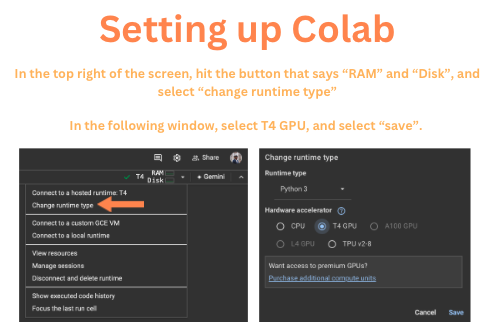

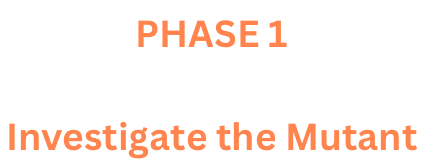

In [1]:
#@title Install dependencies + generate guiding question 1

%%time
#@title Visualize Mutant Protein Structure and PLDDT
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MKHLTPEEKSAVTALWGKVNVLLLLMESFGDLSTPDAVMGNCKVKPDGKKVLGAFTDGLAHLDNLQGTFATLSELDCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH'
jobname = 'test'
# number of models to use
num_relax = 0
template_mode = "none"

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence")
print("length",len(query_sequence.replace(":","")))

USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  if os.environ.get('TPU_NAME', False) != False:
    os.system("pip uninstall -y jax jaxlib")
    os.system("pip install --no-warn-conflicts --upgrade dm-haiku==0.0.10 'jax[cuda12_pip]'==0.3.25 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer biopython") # Added biopython here
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}' biopython") # Added biopython here
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer biopython") # Added biopython here
    os.system("touch AMBER_READY")


# Define the hydrophobic core based on the position of "GRLLVVYPWT" in the original hemoglobin sequence
hydrophobic_core_sequence = "GRLLVVYPWT"
original_sequence = "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH"

# Find positions of the hydrophobic core in the original sequence
core_start_index = original_sequence.find(hydrophobic_core_sequence) + 1
core_positions = list(range(core_start_index, core_start_index + len(hydrophobic_core_sequence)))

# Add "hydrophobic_core" to the residue_categories dictionary
residue_categories = {
    'BPG_binding': [2, 3, 83, 144],
    'iron_binding': [64, 93],
    'not_glycated': [60, 83, 96],
    'cleavage_sites': [8, 9, 26, 27, 30, 31, 36, 37, 38, 39, 46, 47, 53, 54, 57, 58, 60, 72, 73, 75, 76, 85, 86, 93, 94, 105, 106, 111, 112, 120, 121, 123, 124, 129, 130, 141, 142, 145, 146],
    'hydrophobic_core': core_positions  # Positions of the "hydrophobic core"
}

# Define dictionary for residue charges
residue_charge = {
    'K': 'positive',  # Lysine
    'R': 'positive',  # Arginine
    'H': 'positive',  # Histidine (partially positive at physiological pH)
    'D': 'negative',  # Aspartic acid
    'E': 'negative',  # Glutamic acid
    'A': 'neutral',  # Alanine
    'G': 'neutral',  # Glycine
    'V': 'neutral',  # Valine
    'L': 'neutral',  # Leucine
    'I': 'neutral',  # Isoleucine
    'P': 'neutral',  # Proline
    'F': 'neutral',  # Phenylalanine
    'M': 'neutral',  # Methionine
    'W': 'neutral',  # Tryptophan
    'S': 'neutral',  # Serine
    'T': 'neutral',  # Threonine
    'C': 'neutral',  # Cysteine (neutral, though can form disulfide bonds)
    'N': 'neutral',  # Asparagine
    'Q': 'neutral',  # Glutamine
    'Y': 'neutral'   # Tyrosine (polar, but neutral at physiological pH)
}

# Function to query residues based on category
def query_residues_by_category(sequence, category):
    """Query residues in sequence by category and determine charge type."""
    result = []
    for pos in residue_categories[category]:
        if pos <= len(sequence):
            residue = sequence[pos - 1]  # Adjust for 0-based index
            charge = residue_charge.get(residue, 'unknown')
            result.append(f"Position {pos}: {residue} ({charge})")
    return result

# Updated function to print residues by category
def print_residues_by_category(category):
    """Prints residues and their charges based on the selected category."""
    residues_info = query_residues_by_category(mutant_sequence, category)
    print(f"Residues in the category '{category}':")
    for info in residues_info:
        print(info)
    if category == 'hydrophobic_core':
        print("\nCheck for hydrophilic or charged residues in the hydrophobic core!")
        hydrophilic_or_charged = [res for res in residues_info if 'positive' in res or 'negative' in res]
        if hydrophilic_or_charged:
            print("Warning: Hydrophilic or charged residues detected in the hydrophobic core:")
            for res in hydrophilic_or_charged:
                print(res)
            print("Consider changing these residues to hydrophobic (e.g., G, A, V, L, I, P, F, M, W) for stability.")

def calculate_binding_score(sequence):
    """
    Calculate a fictional binding score based on charge properties at specific positions.
    Higher score indicates better binding affinity to oxygen. The score is normalized to a 0-100 scale.
    """
    # Define target positions and their ideal charges for oxygen binding
    target_positions = [2, 3, 83, 144]
    score = 0

    # Scoring based on residue properties at specific positions
    for pos in target_positions:
        if pos <= len(sequence):
            residue = sequence[pos - 1]  # Adjust for 0-based indexing
            if residue in ['D', 'E']:  # Negative charge - good for oxygen binding
                score += 30
            elif residue in ['A', 'G', 'V', 'L', 'I', 'P', 'F', 'M', 'W', 'S', 'T', 'N', 'Q', 'C', 'Y']:  # Neutral - moderate
                score += 15
            elif residue in ['K', 'R', 'H']:  # Positive charge - bad for oxygen binding
                score -= 10

    # Normalize score to 0-100 scale
    max_raw_score = len(target_positions) * 30  # Max score with all ideal residues
    min_raw_score = len(target_positions) * -10  # Min score with all worst residues

    # Ensure score is within the normalized range
    normalized_score = max(0, min(100, int((score - min_raw_score) / (max_raw_score - min_raw_score) * 100)))

    return normalized_score

msa_mode = "mmseqs2_uniref_env"
pair_mode = "unpaired_paired"

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

model_type = "auto"
num_recycles = "3"
recycle_early_stop_tolerance = "auto"
relax_max_iterations = 200
pairing_strategy = "greedy"

max_msa = "auto"
num_seeds = 1
use_dropout = False

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

save_all = False
save_recycles = False
save_to_google_drive = False
dpi = 200

if save_to_google_drive:
  from pydrive2.drive import GoogleDrive
  from pydrive2.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")


import ipywidgets as widgets
from IPython.display import display, clear_output

# Define the question and options with improved formatting
question_text = """
<b>Answer this question after generating the mutant structure in the next cell: Given that the hydrophobic core of the protein sequence occurs from residues 30-40,
what does the PLDDT graph signify about the structure in that portion of the sequence?</b>
"""

options = [
    "The structure is unstable due to repulsive chemical interactions",  # Correct answer
    "The structure is stable due to stabilizing chemical interactions",
]

# Create widgets with improved layout
question_label = widgets.HTML(value=question_text)

options_dropdown = widgets.RadioButtons(
    options=options,
    description="Options:",
    layout=widgets.Layout(width='auto', margin='0 0 10px 0')  # Adjust width and margin
)

# Define the feedback area and button
feedback_label = widgets.HTML()
submit_button = widgets.Button(description="Submit Answer", layout=widgets.Layout(width='150px'))

# Define the function to check the answer
def check_answer(button):
    if options_dropdown.value == "The structure is unstable due to repulsive chemical interactions":
        feedback_label.value = "<span style='color:green;'>Correct! The dip in the graph suggests instability in the region.</span>"
    else:
        feedback_label.value = "<span style='color:red;'>Incorrect. Try again! The dip in the graph suggests instability in the region.</span>"

# Link the button to the function
submit_button.on_click(check_answer)

# Display the question, options, and feedback area
display(question_label, options_dropdown, submit_button, feedback_label)




jobname test_d3cf5
sequence
length 130
installing colabfold...


HTML(value='\n<b>Answer this question after generating the mutant structure in the next cell: Given that the h…

RadioButtons(description='Options:', layout=Layout(margin='0 0 10px 0', width='auto'), options=('The structure…

Button(description='Submit Answer', layout=Layout(width='150px'), style=ButtonStyle())

HTML(value='')

CPU times: user 294 ms, sys: 42 ms, total: 336 ms
Wall time: 56 s


jobname test_b0a68
sequence MKHLTPEEKSAVTALWGKVNVDEVGGEALKKKDDKQRFFESFGDLSTPDAVMGNCKVKPDGKKVLGAFTDGLAHLDNLQGTFATLSELDCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH
length 143
--2024-11-22 23:12:32--  https://raw.githubusercontent.com/sasaigoli05/BIOL105-CompBioModule/main/test_b0a68_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89181 (87K) [text/plain]
Saving to: ‘mutant_protein.pdb’

mutant_protein.pdb  100%[===================>]  87.09K  --.-KB/s    in 0.1s    

2024-11-22 23:12:33 (897 KB/s) - ‘mutant_protein.pdb’ saved [89181/89181]

--2024-11-22 23:12:33--  https://raw.githubusercontent.com/sasaigoli05/BIOL105-CompBioModule/main/Unknown.png
Resolving raw.githubusercontent.com (raw.githubus

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

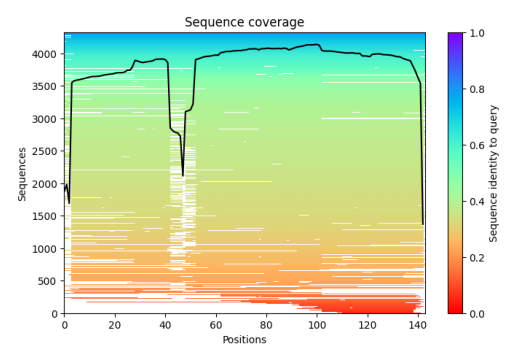

In [2]:
#@title Visualize Mutant Protein Structure and PLDDT
from google.colab import files
import os
import re
import hashlib
import random
import py3Dmol
import glob
import matplotlib.pyplot as plt


from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MKHLTPEEKSAVTALWGKVNVDEVGGEALKKKDDKQRFFESFGDLSTPDAVMGNCKVKPDGKKVLGAFTDGLAHLDNLQGTFATLSELDCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH'
jobname = 'test'
# number of models to use
num_relax = 0
template_mode = "none"

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

# Download pre-generated files from GitHub
pdb_url = "https://raw.githubusercontent.com/sasaigoli05/BIOL105-CompBioModule/main/test_b0a68_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb"
plddt_url = "https://raw.githubusercontent.com/sasaigoli05/BIOL105-CompBioModule/main/Unknown.png"

# Download the files
!wget -O mutant_protein.pdb $pdb_url
!wget -O plddt_scores.png $plddt_url

# Check if files are successfully downloaded
if os.path.exists("mutant_protein.pdb") and os.path.exists("plddt_scores.png"):
    print("Mutant Hemoglobin Structure Generated:")

    # Display 3D Structure with py3Dmol
    import py3Dmol
    view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js')
    with open("mutant_protein.pdb", 'r') as f:
        view.addModel(f.read(), 'pdb')
    view.setStyle({'cartoon': {'colorscheme': {'prop': 'b', 'gradient': 'roygb', 'min': 50, 'max': 90}}})
    view.zoomTo()
    view.show()

    # Display precomputed pLDDT Chart
    import matplotlib.pyplot as plt
    img = plt.imread("plddt_scores.png")
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print("Failed to download files.")




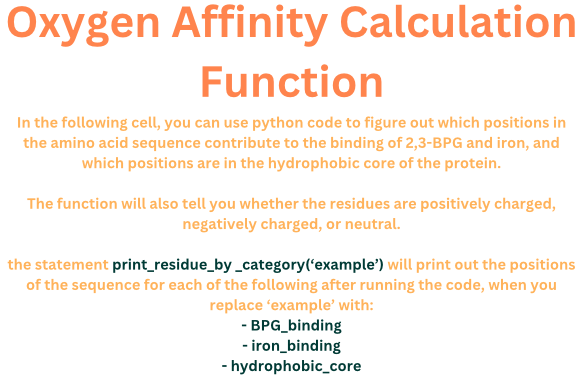

When first running the below cell, you may receive an error. This is because in lines 11 and 12 are functions which will allow you to search for residues involved with BPG binding and inside the hydrophobic core - important residues which are mediating oxygen affinity and the structural integrity of the protein. These will be important to investigate in your journey of fixing the mutant protein!

Use the above instructions box to find out more on how to make changes to the coding function to receive the residues you are looking for after running the cell!

In [3]:
# This code is a function that looks for amino acid residues with specific functions, and prints it out for the user!
def print_residues_by_category(category):
    """Prints residues and their charges based on the selected category."""
    residues_info = query_residues_by_category(query_sequence, category)
    print(f"Residues in the category '{category}':")
    for info in residues_info:
        print(info)

# Call the function with the desired code ('BPG_binding', 'iron_binding', 'hydrophobic_core', 'not_glycated', 'cleavage_sites')


print_residues_by_category('BPG_binding') #THIS IS AN EXAMPLE, YOU SHOULD LOOK FOR THE RESIDUES WHICH ARE MUTATED
print_residues_by_category('example') #THIS IS AN EXAMPLE, YOU SHOULD LOOK FOR THE RESIDUES WHICH ARE MUTATED

# Calculate the score for the modified sequence entered by the student
binding_score = calculate_binding_score(query_sequence)
print(f"THE SEQUENCE HAS A BINDING SCORE OF: {binding_score}.")
print("A higher score means better oxygen binding!")

Residues in the category 'BPG_binding':
Position 2: K (positive)
Position 3: H (positive)
Position 83: A (neutral)


KeyError: 'example'

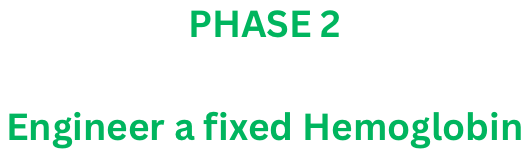

# Mutant Sequence (for reference): MKHLTPEEKSAVTALWGKVNVDEVGGEALKKKDDKQRFFESFGDLSTPDAVMGNCKVKPDGKKVLGAFTDGLAHLDNLQGTFATLSELDCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH

# Based on the residues determined above, make changes to the sequence that will improve the electrical interactions to optimize oxygen binding. (hint: use the guiding questions to help you)

# The below cell initially contains the mutant Hemoglobin sequence. Make changes as you see fit to improve oxygen affinity and structural stability. The results will provide the oxygen affinity score, PLDDT chart, and 3D structure prediction (in that order).

Use the below image to help count the residues (you may have to zoom)!

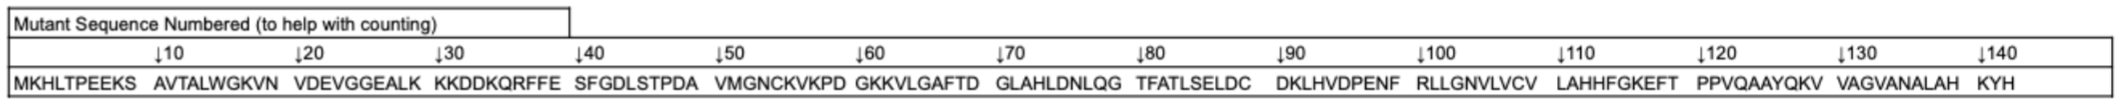

In [ ]:
#@title Generate Guiding Questions 2-4.
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define the question and options with improved formatting
question_text = """
<b>Guiding Question 2: What types of residues are contained in the hydrophobic core of protiens</b>
"""

options = [
    "positive",  # Correct answer
    "negative",
    "neutral"
]

# Create widgets with improved layout
question_label = widgets.HTML(value=question_text)

options_dropdown = widgets.RadioButtons(
    options=options,
    description="Options:",
    layout=widgets.Layout(width='auto', margin='0 0 10px 0')  # Adjust width and margin
)

# Define the feedback area and button
feedback_label = widgets.HTML()
submit_button = widgets.Button(description="Submit Answer", layout=widgets.Layout(width='150px'))

# Define the function to check the answer
def check_answer(button):
    if options_dropdown.value == "neutral":
        feedback_label.value = "<span style='color:green;'>Correct! The inside of a protein is more neutral and hydrophobic, whereas the outside is positively and negatively charged and hydrophillic to interact with polar water molecules</span>"
    else:
        feedback_label.value = "<span style='color:red;'>Incorrect. Try again! The inside of a protein is more neutral and hydrophobic, whereas the outside is positively and negatively charged and hydrophillic to interact with polar water molecules</span>"

# Link the button to the function
submit_button.on_click(check_answer)

# Display the question, options, and feedback area
display(question_label, options_dropdown, submit_button, feedback_label)

#question 3

# Define the question and options with improved formatting
question_text = """
<b>Guiding Question 3: What type of molecule is 2,3-BPG?</b>
"""

options = [
    "large and negative",  # Correct answer
    "large and positive",
    "large and neutral"
]

# Create widgets with improved layout
question_label = widgets.HTML(value=question_text)

options_dropdown = widgets.RadioButtons(
    options=options,
    description="Options:",
    layout=widgets.Layout(width='auto', margin='0 0 10px 0')  # Adjust width and margin
)

# Define the feedback area and button
feedback_label = widgets.HTML()
submit_button = widgets.Button(description="Submit Answer", layout=widgets.Layout(width='150px'))

# Define the function to check the answer
def check_answer(button):
    if options_dropdown.value == "large and negative":
        feedback_label.value = "<span style='color:green;'>Correct! 2,3-BPG is a large and negative molecule which is attracted to positive residues</span>"
    else:
        feedback_label.value = "<span style='color:red;'>Incorrect. Try again! 2,3-BPG is a large and negative molecule which is attracted to positive residues</span>"

# Link the button to the function
submit_button.on_click(check_answer)

# Display the question, options, and feedback area
display(question_label, options_dropdown, submit_button, feedback_label)

#question 4

# Define the question and options with improved formatting
question_text = """
<b>Guiding Question 4: Mutations of hemoglobin which improve 2,3-BPG binding will improve oxygen affinity</b>
"""

options = [
    "true",
    "false",
]

# Create widgets with improved layout
question_label = widgets.HTML(value=question_text)

options_dropdown = widgets.RadioButtons(
    options=options,
    description="Options:",
    layout=widgets.Layout(width='auto', margin='0 0 10px 0')  # Adjust width and margin
)

# Define the feedback area and button
feedback_label = widgets.HTML()
submit_button = widgets.Button(description="Submit Answer", layout=widgets.Layout(width='150px'))

# Define the function to check the answer
def check_answer(button):
    if options_dropdown.value == "false":
        feedback_label.value = "<span style='color:green;'>Correct! The binding 2,3-BPG decreases oxygen affinity</span>"
    else:
        feedback_label.value = "<span style='color:red;'>Incorrect. Try again! The binding 2,3-BPG decreases oxygen affinity</span>"

# Link the button to the function
submit_button.on_click(check_answer)

# Display the question, options, and feedback area
display(question_label, options_dropdown, submit_button, feedback_label)

HTML(value='\n<b>Guiding Question 2: What types of residues are contained in the hydrophobic core of protiens<…

RadioButtons(description='Options:', layout=Layout(margin='0 0 10px 0', width='auto'), options=('positive', 'n…

Button(description='Submit Answer', layout=Layout(width='150px'), style=ButtonStyle())

HTML(value='')

HTML(value='\n<b>Guiding Question 3: What type of molecule is 2,3-BPG?</b>\n')

RadioButtons(description='Options:', layout=Layout(margin='0 0 10px 0', width='auto'), options=('large and neg…

Button(description='Submit Answer', layout=Layout(width='150px'), style=ButtonStyle())

HTML(value='')

HTML(value='\n<b>Guiding Question 4: Mutations of hemoglobin which improve 2,3-BPG binding will improve oxygen…

RadioButtons(description='Options:', layout=Layout(margin='0 0 10px 0', width='auto'), options=('true', 'false…

Button(description='Submit Answer', layout=Layout(width='150px'), style=ButtonStyle())

HTML(value='')

jobname test_d3cf5_0
sequence MKHLTPEEKSAVTALWGKVNVLLLLMESFGDLSTPDAVMGNCKVKPDGKKVLGAFTDGLAHLDNLQGTFATLSELDCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH
length 130
THE SEQUENCE HAS A BINDING SCORE OF: 10.
A higher score means better oxygen binding!


2024-11-22 23:34:45,956 Running on GPU
2024-11-22 23:34:46,671 Found 5 citations for tools or databases
2024-11-22 23:34:46,673 Query 1/1: test_d3cf5_0 (length 130)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:02 remaining: 00:00]


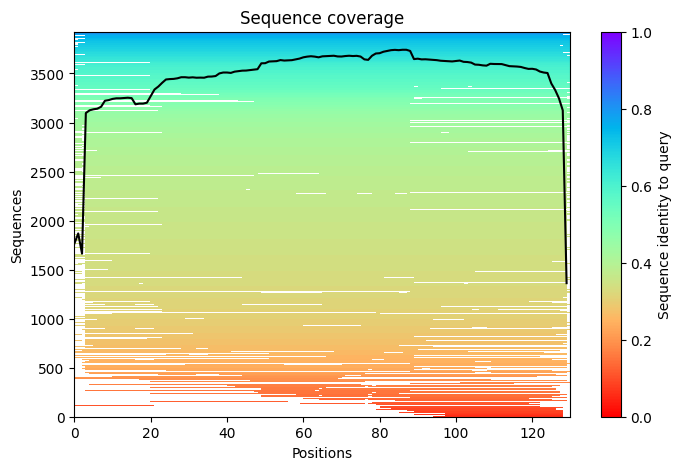

2024-11-22 23:34:49,988 Setting max_seq=512, max_extra_seq=3414
2024-11-22 23:35:29,777 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=78.7 pTM=0.747
2024-11-22 23:35:38,503 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=76.2 pTM=0.734 tol=1.32
2024-11-22 23:35:47,281 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=77.6 pTM=0.74 tol=1.13
2024-11-22 23:35:56,087 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=77.6 pTM=0.736 tol=0.46
2024-11-22 23:35:56,088 alphafold2_ptm_model_1_seed_000 took 53.7s (3 recycles)
2024-11-22 23:35:56,124 reranking models by 'plddt' metric
2024-11-22 23:35:56,124 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=77.6 pTM=0.736
2024-11-22 23:35:56,684 Done


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

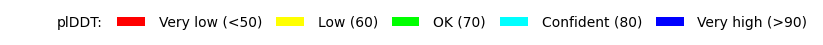

In [4]:
#@title Visualize Engineered Protein Structure and PLDDT
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'MKHLTPEEKSAVTALWGKVNVLLLLMESFGDLSTPDAVMGNCKVKPDGKKVLGAFTDGLAHLDNLQGTFATLSELDCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH' #@param {type:"string"}
jobname = 'test'
# number of models to use
num_relax = 0
template_mode = "none"

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))

# oxygen binding function

binding_score = calculate_binding_score(query_sequence)
print(f"THE SEQUENCE HAS A BINDING SCORE OF: {binding_score}.")
print("A higher score means better oxygen binding!")

# generate structure and plddt for modified


display_images = True

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1
color = "lDDT"
show_sidechains = False
show_mainchains = False

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
setup_logging(Path(log_filename))

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=1,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    input_features_callback=input_features_callback,
    stop_at_score=float(100),
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

# Generate PyMOL 3D structure


tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()